In [ ]:
pip install --upgrade tensorflow
pip install opencv-python-headless

# Resimlerin okunması, resim ve etiket dizilerinin oluşturulması aşaması

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import random
import math
import csv
import cv2
import os

inputBasePath içerisinde her bir sınıf için o sınıf adıyla oluşturulmuş bir klasör vardır ve her klasör içerisinde o sınıfa ait resimler yer almaktadır. bu resimler her analiz adımında yeniden okunup işlenebilir ancak bu okuma sürecini yeniden yeniden yapmamak için resimler bir kereye mahsus okunup, istenirse yeniden boyutlandırılıp, istenirse filtre uygulanıp vs. daha sonra bir numpy array olarak kaydedilir. daha sonraki analiz işlemlerinden direkt bu array okunarak hızlıca işlem yapılabilir. oluştutulan array'ler outputBasePath yoluna kaydedilecek.

In [2]:
inputBasePath    = r"C:\Users\ONUR\Desktop\cats_and_dogs\images"
outputBasePath =  r"C:\Users\ONUR\Desktop\cats_and_dogs\imagearrays" #bu klasörlerin daha önce oluşturulmuş olması gerek

resimler yeniden boyutlandırılmak istenirse genişlik ve yükseklik değerleri burada tanımlanıyor.
özellikle state-of-art modeller resimleri belli ölçülerde daha iyi işliyor. ideal değerleri öğrenip ona göre boyut verilebilir.

Imagenet ile eğitilen VGG16, VGG19 ve ResNet modelleri 224×224 boyutunda,  Inception V3 ve Xception ise 299×299 boyutunda girdiye ihtiyaç duyar.

In [3]:
image_width = 224
image_height = 224

sınıf adlarını tutan bir dizi tanımlanıyor. bu sınıf adları aynı zamanda inputBasePath'te yer alan klasör isimleri

In [4]:
classes = ['cat','dog']

In [5]:
os.chdir(inputBasePath) #chdir -> change directory, inputBasePath yoluyla verilen dizine git

X = [] # resimleri yani girdileri yani X değerlerini tutmak için dizi
Y = [] # etiketleri yani Y değerlerini tutmak için dizi. her bir resmin etiketi içinde yer aldığı klasörün adı zaten

i = 0
for class1 in classes:
  os.chdir(class1) #base yoldan sonra sıradaki sınıfı gösteren klasöre konumlan
  print('=> '+class1) #o an üzerinde bulunulan sınıfı (klasör adını) yaz
  for files in os.listdir('./'): # nokta mevcut dizini gösteriyor. ./ mevcut dizin altındakiler
    img = cv2.imread(files) #dosya yolundan resmi binary array olarak okuma.resmi grayscale almak için ikinci parametreye 0 yazılır cv2.imread(files,0)
    img = cv2.resize(img, (image_width,image_height)) #isteğe bağlı olarak resize edilebilir
    X.append(img) #resmi oluşturan bit dizisini X'e ekle
    Y.append(class1) # bu resmin sınıfı içinde bulunduğu klasör adı. resmin etiketi olarak bunu Y'ye ekle
    i = i + 1
  os.chdir('..') #bir üst dizine çık. bu sınıfla ve bunu içeren klasörler işimiz bitti
  
print("X : ",len(X))
print("Y : ",len(Y))

X = np.array(X).reshape(-1,image_width,image_height,3) #-1 ile verilen ilk değerin yerinde toplam resim adedi var; 
                #bu aynı kalacak. diğer parametreler verilen width ve height'e göre ve resmin renkli olduğunu 
                #belirten 3 ile yeniden şekillendirilecek
Y = np.array(Y) #etiket adlarını içeren Y'yi reshape etmeye gerek yok. 

print("X : ",X.shape)
print("Y : ",Y.shape)

print("X : ",len(X))
print("Y : ",len(Y))

os.chdir('..') #bir üst dizine daha çıkıp sonra imagearrays klasörüne gidersek zaten outputBasePath'e ulaşmış olacağız
os.chdir("imagearrays")
# üstteki iki satır yerine bunu direkt chdir(outputBasePath) olarak da yapabilirdik
np.save(str(image_width)+'x'+str(image_height)+'_images', X) #diziyi kaydederken dosya adını en x boy_images olarak adlandır.
                                                            #'224x224_images' gibi
np.save(str(image_width)+'x'+str(image_height)+'_labels', Y) #diziyi kaydederken dosya adını en x boy_labels olarak adlandır.

print("[ INFO - STAGE1 ]  NUMPY ARRAY CREATION COMPLETED \n ")

=> cat
=> dog
X :  244
Y :  244
X :  (244, 224, 224, 3)
Y :  (244,)
X :  244
Y :  244
[ INFO - STAGE1 ]  NUMPY ARRAY CREATION COMPLETED 
 


# Sınıflandırma işlemleri
Bu aşamadan sonra daha önce oluşturulan array'ler okunarak işlem yapılacak

In [9]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPool2D # üstteki MaxPooling2D ile aynı şey. ister onu ister bunu kullan. 
#kodda ikisi de kullanıldığı için eklendi. yoksa biri ile yapılsaydı da olurdu.
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

data önce numpy array olarak kaydedilen görüntüleri (data) ve sınıf (label) etiketlerini oku

In [6]:
data = np.load(r"C:\Users\ONUR\Desktop\cats_and_dogs\imagearrays\224x224_images.npy")
labels = np.load(r"C:\Users\ONUR\Desktop\cats_and_dogs\imagearrays\224x224_labels.npy")
data.shape

(244, 224, 224, 3)

In [7]:
labels

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'dog', 'dog',

### Label Encoding

array den okunan etiketler orjinal halde, string şeklinde. bunları 0 1 2 şeklinde kodlayacağız yani label encoding yapacağız

In [10]:
labelEn = LabelEncoder() #string olan etiketleri 0 1 2 şeklinde kodla
labels = labelEn.fit_transform(labels)
labels = to_categorical(labels)

In [11]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

### Train - Test Split

In [12]:
#veri array'e kaydedilmeden önce reshape edildiğinden array den okununca da düzgün gelir. yeniden reshape etmeye gerek yok
#eğer array'e atarken son değer 3 olarak yazılmasaydı burada reshape gerekirdi

#data =  data.reshape(-1,image_width , image_height , 3) 
                                                        



# train -test split
#%20 test %80 eğitim seti olacak şekilde böl
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = .20, shuffle = True)


print(
"""
x_train shape: {}
x_test shape: {}
y_train shape: {}
y_test shape: {}

""".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))


x_train shape: (195, 224, 224, 3)
x_test shape: (49, 224, 224, 3)
y_train shape: (195, 2)
y_test shape: (49, 2)




# Normalizasyon (bu adım opsiyonel)
Veriler normalize edilerek piksel değer aralıkları 0-1 aralığına çekilip daha hızlı işlem yapılması sağlanabilir.
Normalizasyon işlem hızını arttırır ama her görüntü için başarı artışı getirmeyebilir, belki başarıyı düşürebilir.

In [13]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### Train - Validation Split

%20 test - %10 validation seti olacak şekilde ayır

validation datası, modelin eğitimi esnasında train verisini doğrulamak için yani eğitim işlemi esnasındaki test sürecini gerçekleştirmek için kullanılıyor.
x_test ve y_test ise eğitim süreci bittikten sonra eğitilen modeli daha önce hiç bilmediği verilerle test etmek için

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = .10, shuffle = True,random_state=42)

### Model tanımlama
kendimize göre bir model oluşturan ve bunu geri döndüren bir fonksiyon yazalım

In [ ]:
def model1(input_shape=(image_width ,image_height ,3), num_classes = 2): #parametrelerin varsayılan değerleri var. 
    #modelin giriş shape'i ve class sayısı= 3                                                                     
    #burada oluşturulan model VGG16 mimarisi aslında. değiştirilebilir.
	model = Sequential()
	chanDim = -1

	model.add(Conv2D(64, (3,3), padding="same",input_shape=input_shape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# 2.Layer (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(128, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# 3.Layer (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(256, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(256, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(256, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# 4.Layer (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# 5.Layer (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(512, (3,3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# 1. TAM BAĞLANTI KATMANI 
	model.add(Flatten())
	model.add(Dense(4096))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# 2. TAM BAĞLANTI KATMANI 
	model.add(Flatten())
	model.add(Dense(4096))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# SOFTMAX
	model.add(Dense(num_classes))
	model.add(Activation("softmax"))

	return model

In [15]:
# bir başka model
def model2(input_shape=(image_width ,image_height ,3), num_classes = 2):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) #ikili sınıflama olsaydı sigmoid kullanılırdı. 
                            #bu durumda zaten num_classes 1 olurdu. yani çıkış nöronu 1 tane olurdu.
    return model

In [16]:
model = model2()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      73792     
                                                        

#### Modeli görselleştirme

In [18]:
pip install pydot #görselleştirme için gerekli kütüphane

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#görselleştirme'


In [19]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


#### Optimizer tanımla
Eğitim işlemi sonucunda ağın bulduğu sonuç ile gerçekte olması gereken sonuç arasındaki fark ile oluşan hatayı loss function ile hesaplıyoruz. Loss fonksiyonu çoklu sınıflamalarda "categorical_crossentropy" , ikili sınıflamada "binary_crossrntropy" olarak seçiliyor. Loss hesaplandıktan sonra geriye yayılımla tüm parametrelerin optimize edilmesi gerekiyor. Bu aşamada kullanılan adım uzunluğu "learning rate" in (LR) duruma göre adaptif bir şekilde değiştirilmesi sonucu daha verimli kılar. "Learning rate" çok küçük olursa işlem uzun sürer, çok büyük olursa hatanın minimum değeri kaçırılabilir. Bu nedenle LR optimize edilmelidir. Bu iş için adaptif momentum optimizer yani "adam" optimizer kullanacağız.

In [20]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#### LR annealer tanımlama
Eğitim esnasında monitör edilen parametrede ilerleme olmuyorsa LR değiştirilir.
Bu işlemi Keras.callbacks içindeki ReduceLROnPlateau fonksiyonu ile yapabiliriz. 

In [21]:
# Set a learning rate annealer
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1,  factor=0.5, min_lr=0.00001)

#### modeli derle

Loss fonksiyonu çoklu sınıflamalarda "categorical_crossentropy" , ikili sınıflamada "binary_crossentropy" olarak seçilir.
burada üç sınıf olduğu için categorical_crossentropy.
çoklu sınıflamada modelin sonundaki sınıflayıcıda (flatten'den sonraki kısım) çıkışta sınıf sayısı kadar nöron olur.

İkili sınıflama yapılıyorsa çıkış nöron sayısı tektir. bu tek çıkış 0 veya 1 olarak bir değer verir. bu durumda loss fonksiyonu binary_crossentropy olur.

DİKKAT: iki sınıfllı bir veri var/yok şeklinde ise ikili sınıflama uygundur. ama kırmızı-siyah, elma-çilek vs. gibi (yani kırmızı kırmızı değil şeklinde değil veya elma elma değil şeklinde yani var yok halinde değil) ve bu sınıflar 1, 2 gibi kodlanmışsa, çıkışta yine 2 nöron olur ve sınıflamada kategoriktir, binary değildir. bu durum aslında yapılan kurgu ile ilgili.

In [22]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

##### epoch ve batch size tanımla

epoch = model kaç iterasyon çalışacak
batch size = resimler modele bit dizisi matrisleri olarak alınır. her bir adımda kaç resmin bit dizisi alınacak, yani kaç resim alınacak. bir seferde alınan resimler yığın (batch), yığındaki resim sayısı batch size

cost fonksiyonu her bir batch için hesaplanır, buna göre geri yayılım yapılır. her bir resim için yapılsaydı süreç uzardı (belki hesap daha hassas olurdu). batch size azaldıkça daha ince hesap yapılır ama süreç uzar, batch size artarsa cost hesabı daha üstünkörü olur, başarı düşebilir. bu nedenle batch size optimum şekilde seçilmeli.

In [24]:
epc = 5 
bs = 8

##### modeli çalıştır

modeli fit edince çalışır. modelin her bir aşamasındaki sonuçlar history değişkenine raporlanır.


In [25]:
history = model.fit(x_train,y_train, batch_size=bs,
                              epochs = epc, validation_data = (x_validate,y_validate),
                              verbose = 1, callbacks=[learning_rate_reduction])

Epoch 1/5
22/22 [==============================] - 22s 985ms/step - loss: 0.8483 - accuracy: 0.5486 - val_loss: 0.7032 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/5
22/22 [==============================] - 22s 987ms/step - loss: 0.7123 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 3/5
22/22 [==============================] - 22s 991ms/step - loss: 0.6905 - accuracy: 0.5086 - val_loss: 0.6950 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 4/5
22/22 [==============================] - 22s 981ms/step - loss: 0.6816 - accuracy: 0.5429 - val_loss: 0.6964 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 5/5
22/22 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.5886
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
22/22 [==============================] - 22s 982ms/step - loss: 0.6666 - accuracy: 0.5886 - val_loss: 0.6839 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [26]:
# history nin içindeki history değerinin anahtarları raporu alınabilecek değerlerin adlarını gösterir
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

#### Doğruluk grafiklerini çiz

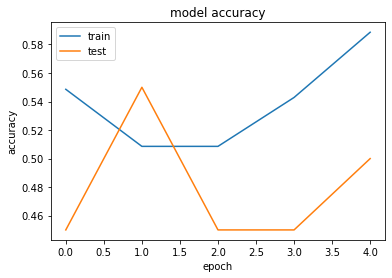

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Hata grafiklerini çiz

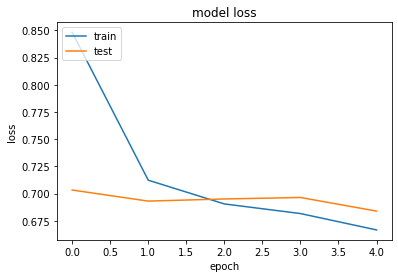

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

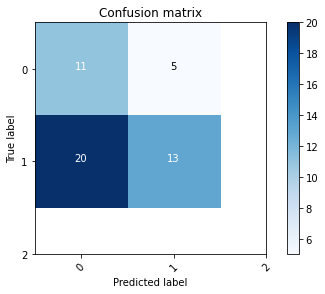

In [30]:

Y_pred = model.predict(x_test)   
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)  #test süreci için Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [31]:
from sklearn.metrics import classification_report
report = classification_report(Y_true, Y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.35      0.69      0.47        16
           1       0.72      0.39      0.51        33

    accuracy                           0.49        49
   macro avg       0.54      0.54      0.49        49
weighted avg       0.60      0.49      0.50        49



İstenirse eğitilen model daha sonra kullanılmak üzere, hesaplanan ağırlıkları ile kaydedilebilir. bunun için de bir yol tanımlaması yapabiliriz.

In [ ]:
  os.chdir(r"C:\Users\ONUR\Desktop\cats_and_dogs\models") #modeli kaydetmek için 
  model.save('model1.h5')

##### bir başka test işlemi ve confusion matrix çizimi
bu kez test dataları kullanılarak hesap yapılıyor. confusion matrix üsttekinden stil olarak daha farklı çizdiirliyor

In [33]:
# model = load_model(r"C:\Users\ONUR\Desktop\cats_and_dogs\models\model1.h5")
preds = model.predict(x_test)
y_pred = np.zeros_like(preds)
y_pred[np.arange(len(preds)), preds.argmax(1)] = 1
classes = ['cat','dog']
confusionMatrix = np.zeros((len(classes),len(classes)))

for i in range(len(y_test)):

  if np.array_equal(y_pred[i],y_test[i]):
    index = np.argmax(y_test[i])
    confusionMatrix[index,index] += 1

  else:

    index1 = np.argmax(y_test[i])
    index2 = np.argmax(y_pred[i])
    confusionMatrix[index1,index2] += 1

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.35      0.69      0.47        16
           1       0.72      0.39      0.51        33

   micro avg       0.49      0.49      0.49        49
   macro avg       0.54      0.54      0.49        49
weighted avg       0.60      0.49      0.50        49
 samples avg       0.49      0.49      0.49        49

Accuracy Score : 
0.4897959183673469
--------------------------------------------------
Confusion Matrix : 
[[11.  5.]
 [20. 13.]]
--------------------------------------------------


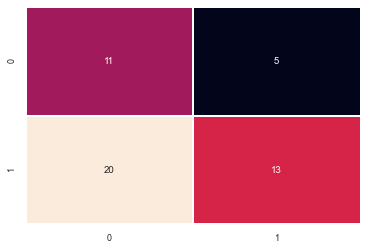

In [34]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))
print("Accuracy Score : ")
print(accuracy_score(y_test, y_pred))
cm = accuracy_score(y_test, y_pred)
sns.set(font_scale=0.8)
sns.heatmap(confusionMatrix,annot=True, linewidths=1.0, cbar=False)
print("--------------------------------------------------")
print("Confusion Matrix : ")
print(confusionMatrix)
print("--------------------------------------------------")

## Veri Arrtırımı (Data Augmentation)
Bu işlem opsiyonel olarak yapılır.
Daha iyi öğrenme ve overfitting probleminin önüne geçmek için elimizdeki mevcut verileri belirli biçimde dönüştürerek yeni yapay örnekler elde edip, elimizdeki örnekleri çeşitlendirebiliriz.

In [35]:
#ImageDataGenerator ile veri arttırım modelini kurgula ve datagen değikenine ata
datagen = ImageDataGenerator(  
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180) 10 degrees
        zoom_range = 0.1, # Randomly zoom image %10
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width) %10
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height) %10
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False  # randomly flip images
                        )
datagen.fit(x_train) #datagen'i x_train üzerinden çalıştır ve veri üret

##### Üretilen resimlerden görüntüle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


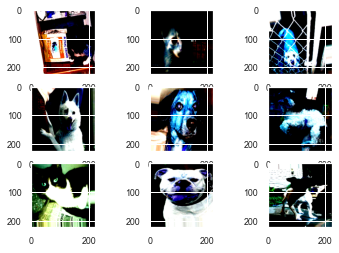

In [36]:
from matplotlib import pyplot
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(224, 224,3))
	# show the plot
	pyplot.show()
	break

### Veri arttırımı ile birlikte modeli fit et
Veri arttırımı uygulayarak modeli tekrar fit et ve sonuçları izle
Bunun için fit_generator metodu kullanılır.

In [37]:
history = model.fit_generator(datagen.flow(np.array(x_train),np.array(y_train), batch_size=bs), 
                              epochs = epc, validation_data = datagen.flow(np.array(x_validate),
                             np.array(y_validate),batch_size=bs),verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // bs, 
                              callbacks=[learning_rate_reduction])

<ipython-input-37-b23f220295aa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(np.array(x_train),np.array(y_train), batch_size=bs),


Epoch 1/5
21/21 [==============================] - 23s 1s/step - loss: 0.6562 - accuracy: 0.6108 - val_loss: 0.6888 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 2/5
21/21 [==============================] - 21s 1s/step - loss: 0.6711 - accuracy: 0.5868 - val_loss: 0.6744 - val_accuracy: 0.5500 - lr: 5.0000e-05
Epoch 3/5
21/21 [==============================] - 21s 990ms/step - loss: 0.6549 - accuracy: 0.6228 - val_loss: 0.6899 - val_accuracy: 0.6000 - lr: 5.0000e-05
Epoch 4/5
21/21 [==============================] - 21s 977ms/step - loss: 0.6442 - accuracy: 0.5928 - val_loss: 0.6743 - val_accuracy: 0.5500 - lr: 5.0000e-05
Epoch 5/5
21/21 [==============================] - 20s 938ms/step - loss: 0.6298 - accuracy: 0.6766 - val_loss: 0.6920 - val_accuracy: 0.5000 - lr: 5.0000e-05


Bu işlemin ardından model tekrar test edilebilir, sonuçlara, confusion matrix'e yukarıda yapılanların benzerleri ile ulaşılabilir.

### PRE_TRAINED MODEL UYGULAMA

In [38]:
from keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=(image_width ,image_height ,3)
   
)

In [39]:
NUM_CLASSES=2
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False #ilk katmana eklenen vgg16 modelini tekrar  train etme, 
                                #imagenet'te train edilmiş ağırlıkları kullan

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

istersen data augmentation olmadan fit et

In [42]:
history = model.fit(x_train,y_train, batch_size=bs,
                              epochs = epc, validation_data = (x_validate,y_validate),
                              verbose = 1, callbacks=[learning_rate_reduction])

Epoch 1/5
22/22 [==============================] - 21s 953ms/step - loss: 0.8299 - accuracy: 0.6000 - val_loss: 0.4069 - val_accuracy: 0.8000 - lr: 5.0000e-05
Epoch 2/5
22/22 [==============================] - 21s 974ms/step - loss: 0.3877 - accuracy: 0.8057 - val_loss: 0.2709 - val_accuracy: 0.9500 - lr: 5.0000e-05
Epoch 3/5
22/22 [==============================] - 21s 937ms/step - loss: 0.2247 - accuracy: 0.9257 - val_loss: 0.2596 - val_accuracy: 0.9000 - lr: 5.0000e-05
Epoch 4/5
22/22 [==============================] - 20s 904ms/step - loss: 0.1715 - accuracy: 0.9314 - val_loss: 0.2117 - val_accuracy: 0.9500 - lr: 5.0000e-05
Epoch 5/5
22/22 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9429
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
22/22 [==============================] - 19s 889ms/step - loss: 0.1653 - accuracy: 0.9429 - val_loss: 0.2238 - val_accuracy: 0.9500 - lr: 5.0000e-05


istersen data augmentation kullanarak fit et

In [ ]:
history = model.fit_generator(datagen.flow(np.array(x_train),np.array(y_train), batch_size=bs), 
                              epochs = epc, validation_data = datagen.flow(np.array(x_validate),
                             np.array(y_validate),batch_size=bs),verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // bs, 
                              callbacks=[learning_rate_reduction])